# Donor - Receiver Attribute Difference Analysis

In [46]:
# imports
import yaml
import pandas as pd

In [47]:
# read configuration (algorithm parameters etc) into dictionary
with open('../data/config.yaml', 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## read in the attributes table for all donors and receivers

In [54]:
# read donor attributes
dtAttrDonor = pd.read_csv('../data/all_attrs_donors.csv')
dtAttrDonor['sand_frac'] = (dtAttrDonor['sand_frac']/100).round(2)
dtAttrDonor['clay_frac'] = (dtAttrDonor['clay_frac']/100).round(2)
dtAttrDonor['prcFlatUpland'] = (dtAttrDonor['prcFlatUpland']*100).round(0)
dtAttrDonor['prcFlatLowland'] = (dtAttrDonor['prcFlatLowland']*100).round(0)
dtAttrDonor['prcFlattotal'] = (dtAttrDonor['prcFlatTotal']*100).round(0)

# read receiver attributes
dtAttrReceiver = pd.read_csv('../data/all_attrs_receivers.csv')
dtAttrReceiver['sand_frac'] = (dtAttrReceiver['sand_frac']/100).round(2)
dtAttrReceiver['clay_frac'] = (dtAttrReceiver['clay_frac']/100).round(2)
dtAttrReceiver['prcFlatUpland'] = (dtAttrReceiver['prcFlatUpland']*100).round(0)
dtAttrReceiver['prcFlatLowland'] = (dtAttrReceiver['prcFlatLowland']*100).round(0)
dtAttrReceiver['prcFlattotal'] = (dtAttrReceiver['prcFlatTotal']*100).round(0)


## load donor-receiver pairing and compute attribute difference

In [49]:
# loop through regionalization algorithms and scenarios
statsAll = dfDiff = pd.DataFrame()
for reg_alg in ['kmeans_clust','kmedoids_clust','gower_dist','random_forest']:
    for reg_scenario in ['hlr', 'camels']:
        
        pair_file = '../output/donor_' + reg_scenario + '_' + reg_alg + '.csv'
        dtDonor =  pd.read_csv(pair_file)
        
        ## compute donor-receiver attribute difference
        # first merge receiver attributes with donor table
        dt1 = pd.merge(dtDonor[['id','tag','donor','distSpatial']], dtAttrReceiver[['id'] + config['attrs'][reg_scenario]],on='id')

        # then merge in donor attributes
        dt2 = pd.merge(dt1, dtAttrDonor[['id'] + config['attrs'][reg_scenario]],left_on='donor',right_on='id',suffixes=("_r", "_d"))

        # compute donor-receiver attribute difference
        for x in config['attrs'][reg_scenario]:
            dt2[x+'_diff'] = abs(dt2[x+'_d'] - dt2[x+'_r']).round(2)
        
        # add to the overall dataframe for differences
        cols = [c1 for c1 in dt2.columns if c1.endswith("_diff")]
        dt2 = dt2[cols]
        #print(dt2.columns)
        dt2.columns = [x.replace("_diff","",1) for x in dt2.columns] 
        #print(dt2.columns)
        dt2.insert(0,column="reg_scenario",value=reg_scenario)
        dt2.insert(0,column="reg_algorithm",value=reg_alg)
        dfDiff = dfDiff.append(dt2)
                    
        # summarize donor-receiver attribute differences
        stats = None
        for a1 in config['attrs'][reg_scenario]:
            x = dt2[a1].describe().to_frame()
            x.columns = [a1]
            if stats is None:
                stats = x
            else:
                stats = stats.join(x)   
        stats.insert(0, column="reg_scenario",value=reg_scenario)
        stats.insert(0, column="reg_algorithm",value=reg_alg)
        
        statsAll = statsAll.append(stats)
        
statsAll.to_csv("../output/stats_donor_receiver_attribute_difference.csv", index=False)

## randomly chosen donors

In [50]:
import os
import random

# start from the receiver attributes table
dtDonor_rand = dtAttrReceiver.copy()

# load precomputed spatial distance between all receivers and donors
f1 = '../data/dist_spatial_donor_receiver.csv'
if os.path.isfile(f1):
    distSpatial0 = pd.read_csv(f1,index_col=0)
else:
    pass

# maximum distance (result: 729km - smaller than the max distance specified in config)
print("Maximum spatial distance: " + str(distSpatial0.max().max()))

# randomly select a donor for each receiver
dtDonor_rand['donor'] = random.choices(distSpatial0.columns.to_list(),k=len(dtDonor_rand))

Maximum spatial distance: 729


## compute attribute difference for random donors

In [51]:
# merge with donor attributes and compute the differences
attrs = list(set(config['attrs']['hlr'] + config['attrs']['camels']))
dfDiff2 = pd.merge(dtDonor_rand[['id','donor']+attrs], dtAttrDonor[['id']+attrs], left_on = "donor", right_on="id",suffixes=("_r", "_d"))

# compute donor-receiver attribute difference
for x in attrs:
    dfDiff2[x+'_diff'] = abs(dfDiff2[x+'_d'] - dfDiff2[x+'_r']).round(2)
        
# add to the overall dataframe for differences
cols = [c1 for c1 in dfDiff2.columns if c1.endswith("_diff")]
dfDiff2 = dfDiff2[cols]
dfDiff2.columns = [x.replace("_diff","",1) for x in dfDiff2.columns] 

## Summarize receiver-donor attribute difference in boxplots

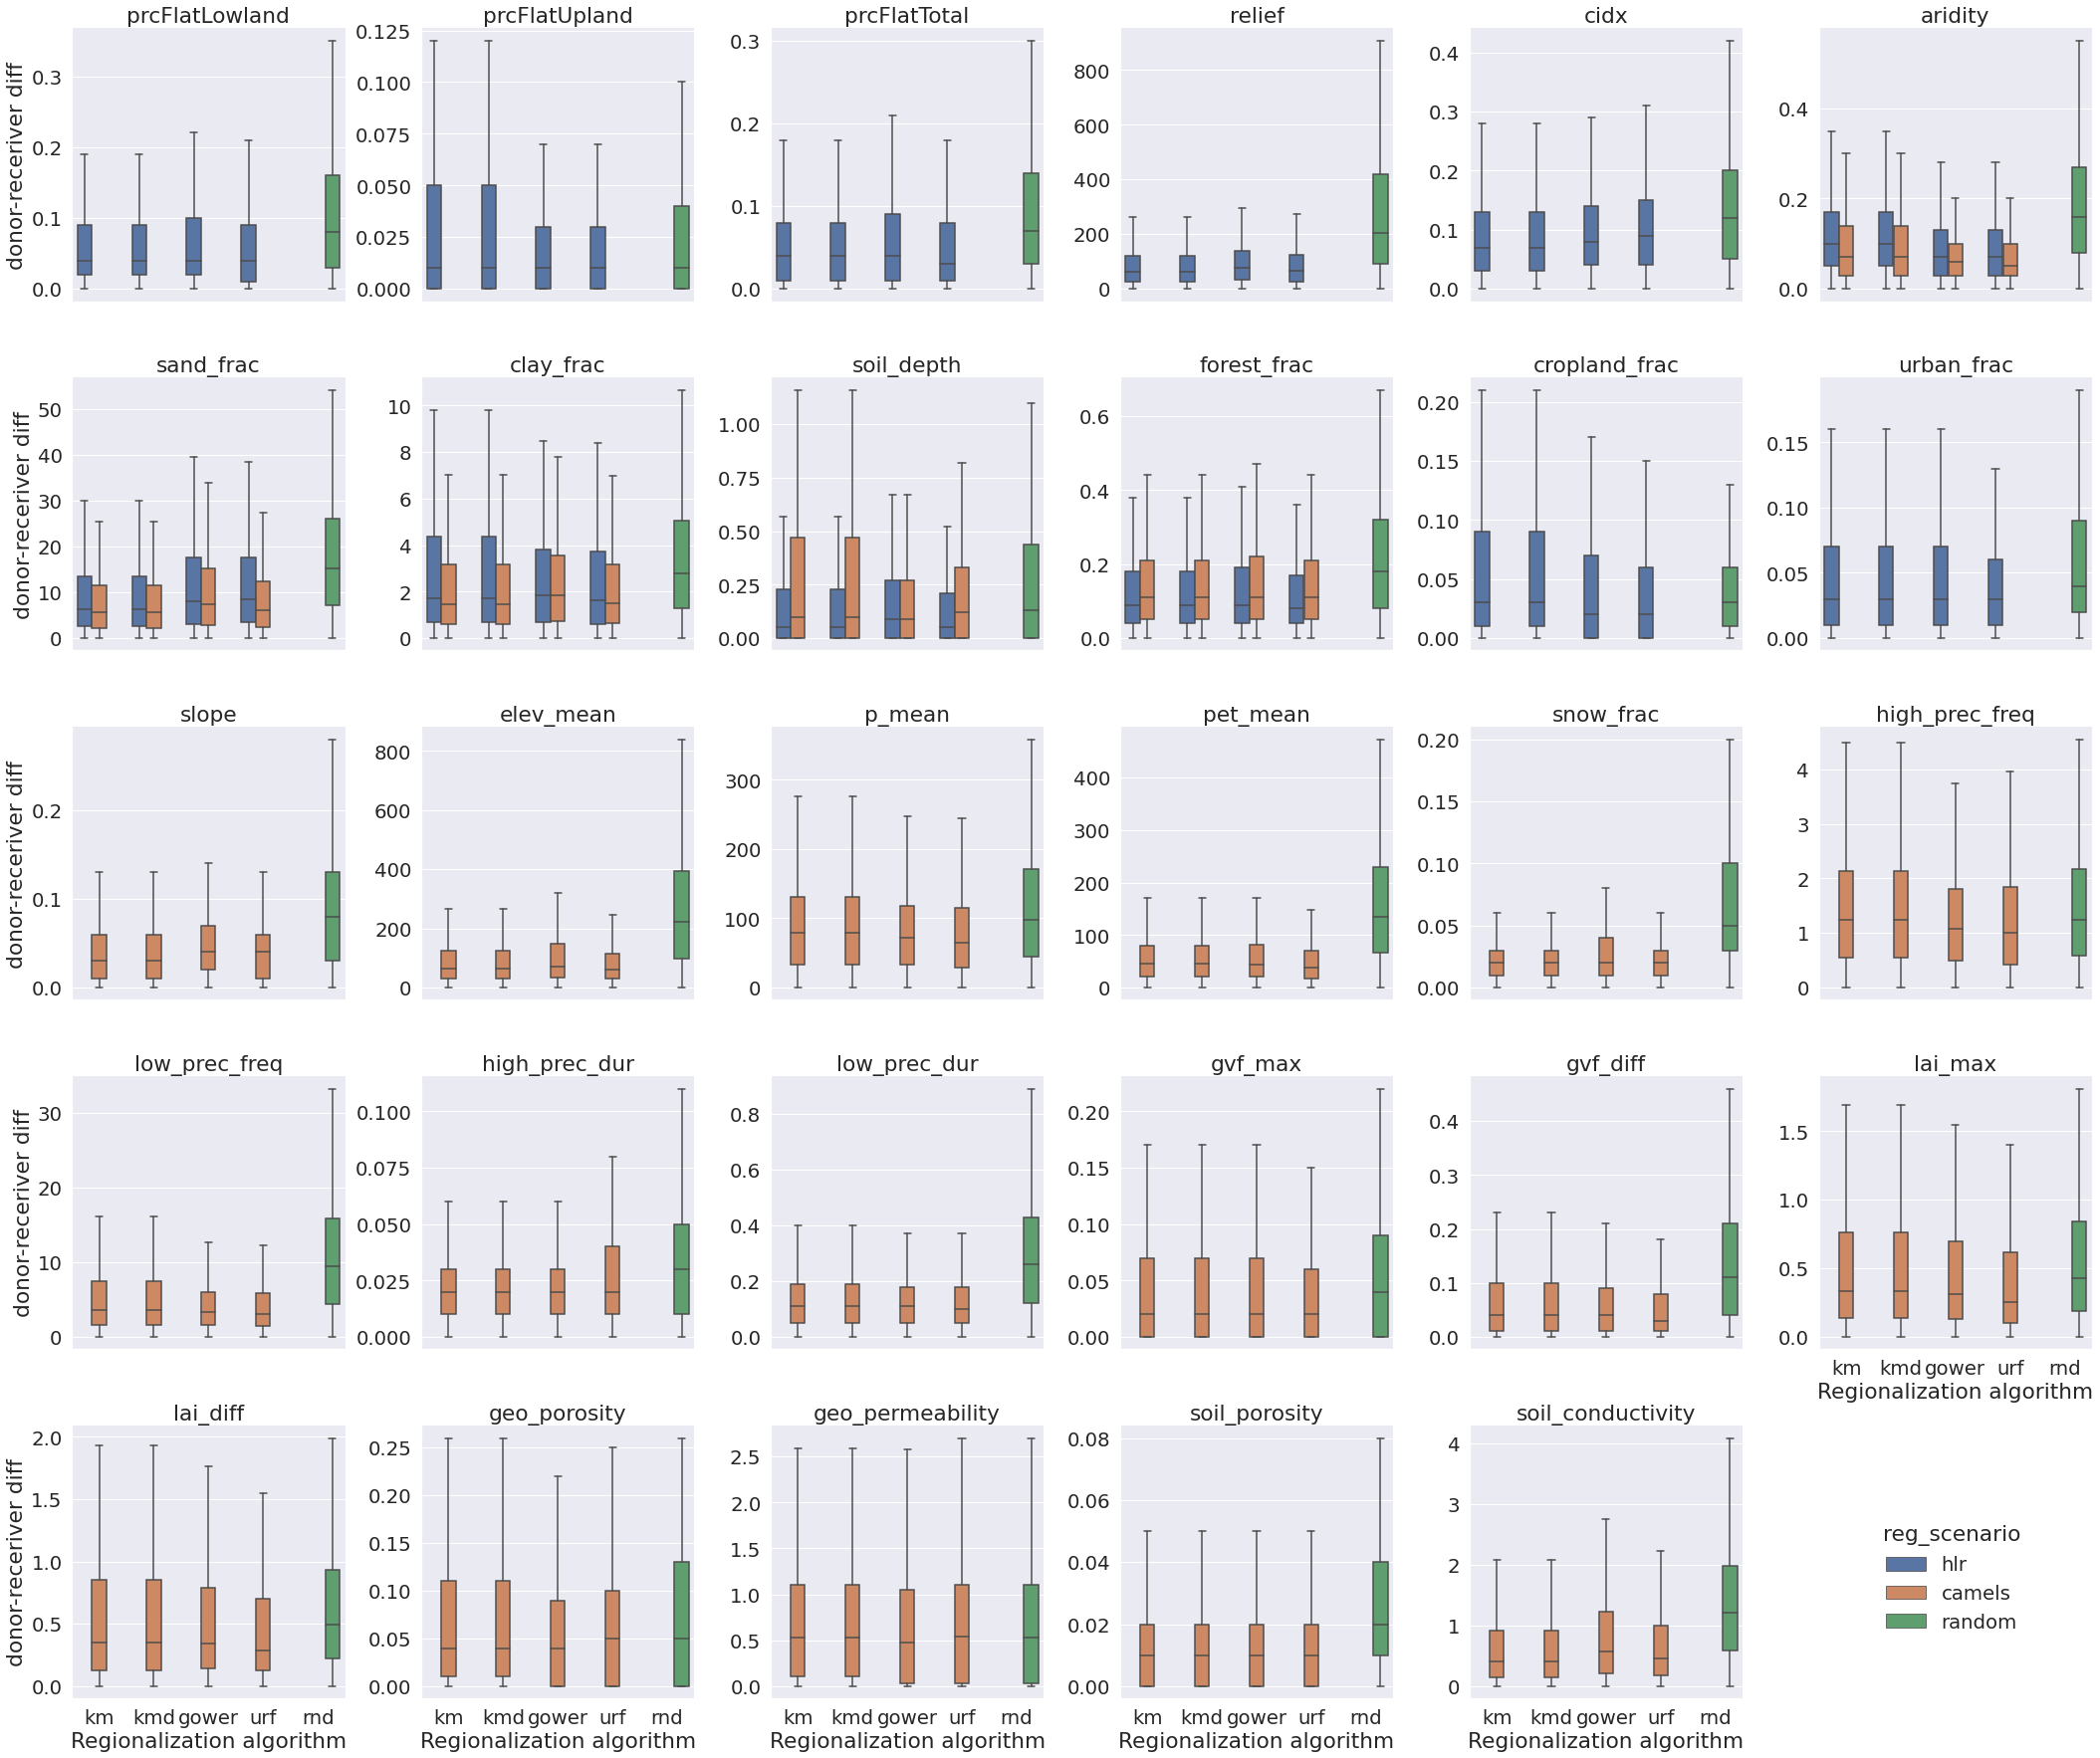

In [52]:
# make boxplots of attribute differences
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set(font_scale=1.8)

dfDiff2['reg_scenario'] = dfDiff2['reg_algorithm'] = 'random'
dfDiff = dfDiff.append(dfDiff2)
dfDiff1 = dfDiff.melt(id_vars=['reg_algorithm','reg_scenario'])
dict = {'kmeans_clust':'km', 'kmedoids_clust':'kmd', 'gower_dist':'gower', 'random_forest':'urf', 'random':'rand'}
dfDiff1 = dfDiff1.replace({'reg_algorithm': dict})

g = sns.catplot(data= dfDiff1, kind="box",x="reg_algorithm", y="value", col="variable", col_wrap=6, hue='reg_scenario',
                showfliers = False,sharey=False,legend=True)
g.set_xlabels('Regionalization algorithm')
g.set_ylabels('donor-receriver diff')

for col_key,ax in g.axes_dict.items():
    ax.set_title(col_key)
sns.move_legend(g, "lower right", bbox_to_anchor=(.9, .07))
plt.savefig("../figs/boxplot_attr_diff.png",dpi=500)
